## Income Prediciton

The dataset is credited to Ronny Kohavi and Barry Becker and was drawn from the 1994 United States Census Bureau data and involves using personal details such as education level to predict whether an individual will earn more or less than $50,000 per year.

The dataset provides 14 input variables that are a mixture of categorical, ordinal, and numerical data types. The complete list of variables is as follows:

- Age.
- Workclass.
- Final Weight.
- Education.
- Education Number of Years.
- Marital-status.
- Occupation.
- Relationship.
- Race.
- Sex.
- Capital-gain.
- Capital-loss.
- Hours-per-week.
- Native-country.

There are a total of 48,842 rows of data, and 3,620 with missing values, leaving 45,222 complete rows.

There are two class values ‘>50K‘ and ‘<=50K‘, meaning it is a binary classification task. The classes are imbalanced, with a skew toward the ‘<=50K‘ class label.



### We will include the following contents:
- Data Exploration
    - Load Dataset
    - Data Statistics
- Bias Analysis
    - Bias Metric
    - Fairness Visualization
- Fair machine learning methods
    - Fair constrainted learning
    - Fair Representation

<p style="page-break-after:always;"></p>

### Data Exploration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = ["Age", "Workclass", "Final Weight", "Education", "Education Number of Years", "Marital-status", "Occupation", "Relationship", "Race", "Gender", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
df = pd.read_csv("../datasets/adult/raw/adult.data", index_col=None, header=None, names=columns)
print(df.shape)
df.head()

(32561, 15)


,Age,Workclass,Final Weight,Education,Education Number of Years,Marital-status,Occupation,Relationship,Race,Gender,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<Axes: title={'center': 'Male'}, ylabel='Income'>

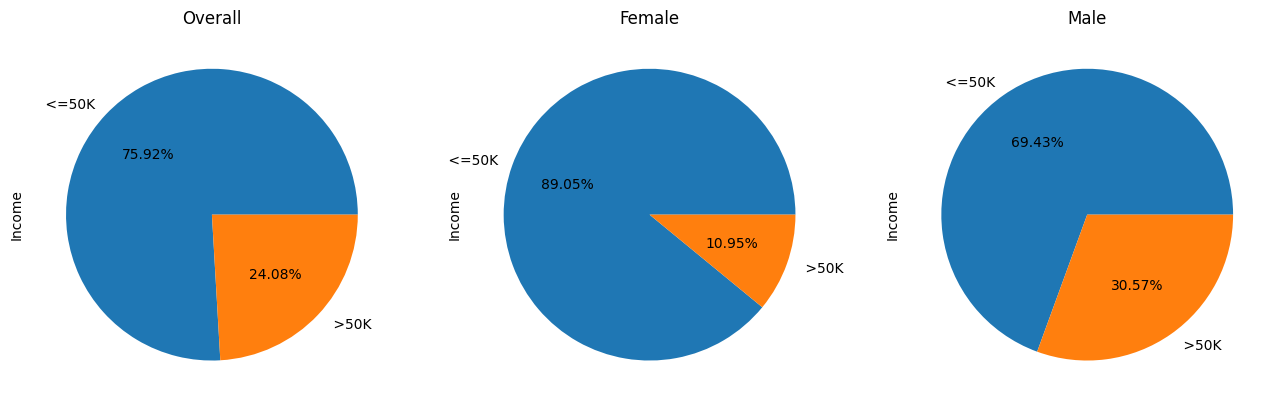

In [4]:
fig,ax=plt.subplots(ncols=3,figsize=(16,5))
df["Income"].value_counts().plot.pie(autopct="%.2f%%",ax=ax[0], title="Overall")
df[df["Gender"]==" Female"]["Income"].value_counts().plot.pie(autopct="%.2f%%",ax=ax[1], title="Female")
df[df["Gender"]==" Male"]["Income"].value_counts().plot.pie(autopct="%.2f%%",ax=ax[2], title = "Male")

### Bias Analysis

Take the age as exmaple, we can run the following command to get the fairness analysis results:


In [5]:

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '../src'))
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tabulate import tabulate


from dataset import load_german_data, load_adult_data
from utils import seed_everything, PandasDataSet, print_metrics, clear_lines, InfiniteDataLoader
from metrics import metric_evaluation
from networks import MLP

from loss import DiffDP


In [6]:
def train_step(model, data, target, sensitive, scheduler, optimizer, clf_criterion, fair_criterion, lam, device, args=None):
    model.train()
    optimizer.zero_grad()
    h, output = model(data)
    clf_loss = clf_criterion(output, target)
    fair_loss = fair_criterion(output, sensitive)
    loss = clf_loss + lam * fair_loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    return model, loss.item(), clf_loss.item(), fair_loss.item()

def test(model, test_loader, clf_criterion, fair_criterion, lam, device, prefix="test", args=None):
    model.eval()
    clf_loss = 0
    fair_loss = 0
    target_hat_list = []
    target_list = []
    sensitive_list = []

    with torch.no_grad():
        for data, target, sensitive in test_loader:
            data, target, sensitive = (data.to(device), target.to(device), sensitive.to(device))
            h, output = model(data)

            clf_loss += clf_criterion(output, target).item()
            fair_loss += fair_criterion(output, sensitive).item()
            target_hat_list.append(output.cpu().numpy())
            target_list.append(target.cpu().numpy())
            sensitive_list.append(sensitive.cpu().numpy())

    target_hat_list = np.concatenate(target_hat_list, axis=0)
    target_list = np.concatenate(target_list, axis=0)
    sensitive_list = np.concatenate(sensitive_list, axis=0)
    metric = metric_evaluation(y_gt=target_list, y_pre=target_hat_list, s=sensitive_list, prefix=f"{prefix}")

    clf_loss /= len(test_loader)
    fair_loss /= len(test_loader)
    
    metric[f"{prefix}/clf_loss"] = clf_loss
    metric[f"{prefix}/fair_loss"] = fair_loss
    metric[f"{prefix}/loss"] = clf_loss + lam*fair_loss
    metric[f"{prefix}/y_hat"] = target_hat_list
    metric[f"{prefix}/sensitive"] = sensitive_list

    return metric



In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = "german"
sensitive_attr = "sex"
seed = 42
batch_size = 64
lr = 1e-2
mlp_layers = "256,256"
evaluation_metrics = "acc,dp"
num_training_steps = 200



# X, y, s = load_german_data(path="../datasets/german/raw", sensitive_attribute=sensitive_attr)
X, y, s = load_adult_data(path="../datasets/adult/raw", sensitive_attribute=sensitive_attr)

categorical_cols = X.select_dtypes("string").columns
if len(categorical_cols) > 0:
    X = pd.get_dummies(X, columns=categorical_cols)


n_features = X.shape[1]
n_classes = len(np.unique(y))

X_train, X_testvalid, y_train, y_testvalid, s_train, s_testvalid = train_test_split(X, y, s, test_size=0.6, stratify=y, random_state=seed)
X_test, X_val, y_test, y_val, s_test, s_val = train_test_split(X_testvalid, y_testvalid, s_testvalid, test_size=0.5, stratify=y_testvalid, random_state=seed)

dataset_stats = {
    "dataset": dataset,
    "num_features": X.shape[1],
    "num_classes": len(np.unique(y)),
    "num_sensitive": len(np.unique(s)),
    "num_samples": X.shape[0],
    "num_train": X_train.shape[0],
    "num_val": X_val.shape[0],
    "num_test": X_test.shape[0],
    "num_y1": (y.values == 1).sum(),
    "num_y0": (y.values == 0).sum(),
    "num_s1": (s.values == 1).sum(),
    "num_s0": (s.values == 0).sum(),
}

# Create the table using the tabulate function
table = tabulate([(k, v) for k, v in dataset_stats.items()], tablefmt='grid')

print(table)


+---------------+--------+
| dataset       | german |
+---------------+--------+
| num_features  | 101    |
+---------------+--------+
| num_classes   | 2      |
+---------------+--------+
| num_sensitive | 2      |
+---------------+--------+
| num_samples   | 45222  |
+---------------+--------+
| num_train     | 18088  |
+---------------+--------+
| num_val       | 13567  |
+---------------+--------+
| num_test      | 13567  |
+---------------+--------+
| num_y1        | 11208  |
+---------------+--------+
| num_y0        | 34014  |
+---------------+--------+
| num_s1        | 30527  |
+---------------+--------+
| num_s0        | 14695  |
+---------------+--------+


In [8]:
numurical_cols = X.select_dtypes("float32").columns
if len(numurical_cols) > 0:
    # scaler = StandardScaler().fit(X[numurical_cols])

    def scale_df(df, scaler):
        return pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

    scaler = StandardScaler().fit(X_train[numurical_cols])

    def scale_df(df, scaler):
        return pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

    X_train[numurical_cols] = X_train[numurical_cols].pipe(scale_df, scaler)
    X_val[numurical_cols]   = X_val[numurical_cols].pipe(scale_df, scaler)
    X_test[numurical_cols]  = X_test[numurical_cols].pipe(scale_df, scaler)


train_data = PandasDataSet(X_train, y_train, s_train)
val_data = PandasDataSet(X_val, y_val, s_val)
test_data = PandasDataSet(X_test, y_test, s_test)


train_infinite_loader = InfiniteDataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [9]:
mlp_layers = [int(x) for x in mlp_layers.split(",")]
net = MLP(n_features=n_features, num_classes=1, mlp_layers=mlp_layers ).to(device)
clf_criterion = nn.BCELoss()
fair_criterion = DiffDP()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

print(net)


MLP(
  (network): ModuleList(
    (0): Linear(in_features=101, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (head): Linear(in_features=256, out_features=1, bias=True)
)


In [10]:
lam = 0
logs = []
headers = ["Step(Tr|Val|Te)"] + evaluation_metrics.split(",")

# evaluation_metrics = "ap,dp,prule"


for step, (X, y, s) in enumerate(train_infinite_loader):
    if step >= num_training_steps:
        break

    X, y, s = X.to(device), y.to(device), s.to(device)
    net, loss, clf_loss, fair_loss = train_step(model=net, data=X, target=y, sensitive=s, optimizer=optimizer, scheduler=scheduler,  clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam,  device=device)


    if step % 20 == 0:
        train_metrics = test(model=net, test_loader=train_loader, clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam, device=device, prefix="train")
        val_metrics   = test(model=net, test_loader=val_loader,   clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam, device=device, prefix="val")
        test_metrics  = test(model=net, test_loader=test_loader,  clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam, device=device, prefix="test")
        res_dict = {}
        res_dict.update(train_metrics)
        res_dict.update(val_metrics)
        res_dict.update(test_metrics)
        res = print_metrics(res_dict, evaluation_metrics, train=True)
        logs.append( [ step, *res] )
            
table = tabulate(logs, headers=headers, tablefmt="grid", floatfmt="02.2f")
print(table)


+-------------------+-------------------+-------------------+
|   Step(Tr|Val|Te) | acc               | dp                |
+===================+===================+===================+
|                 0 | 75.22|75.22|75.21 | 0.00|0.00|0.00    |
+-------------------+-------------------+-------------------+
|                20 | 83.24|82.52|82.69 | 11.83|11.69|11.01 |
+-------------------+-------------------+-------------------+
|                40 | 84.54|83.93|84.06 | 16.19|16.87|15.69 |
+-------------------+-------------------+-------------------+
|                60 | 85.06|84.25|84.42 | 17.94|18.54|17.53 |
+-------------------+-------------------+-------------------+
|                80 | 85.16|84.40|84.48 | 17.77|18.20|17.31 |
+-------------------+-------------------+-------------------+
|               100 | 85.19|84.49|84.55 | 18.61|18.96|18.14 |
+-------------------+-------------------+-------------------+
|               120 | 85.18|84.49|84.58 | 18.56|18.97|18.12 |
+-------

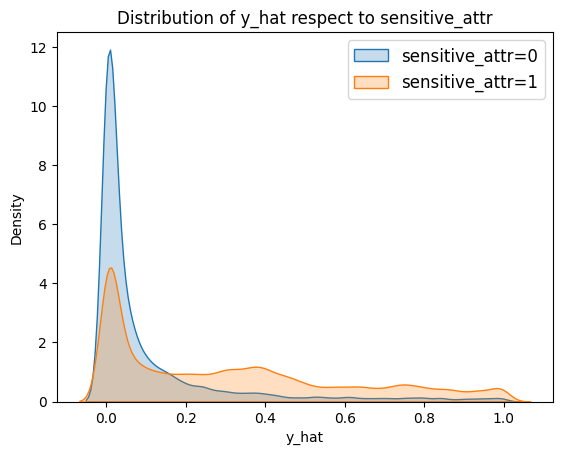

In [11]:
y_hat = train_metrics["train/y_hat"].reshape(-1)
sensitive_attr = train_metrics["train/sensitive"].reshape(-1)
import seaborn as sns
import matplotlib.pyplot as plt

# Separate y_hat based on sensitive_attr
y_hat_0 = y_hat[sensitive_attr == 0]
y_hat_1 = y_hat[sensitive_attr == 1]

sns.kdeplot(y_hat_0, bw_adjust=.5, label='sensitive_attr=0', shade=True)
sns.kdeplot(y_hat_1, bw_adjust=.5, label='sensitive_attr=1', shade=True)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Distribution of y_hat respect to sensitive_attr')
plt.xlabel('y_hat')
plt.ylabel('Density')

plt.show()

In [12]:
net = MLP(n_features=n_features, num_classes=1, mlp_layers=mlp_layers ).to(device)
clf_criterion = nn.BCELoss()
fair_criterion = DiffDP()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
print(net)
lam = 0.88
logs = []
headers = ["Step(Tr|Val|Te)"] + evaluation_metrics.split(",")

# evaluation_metrics = "ap,dp,prule"


for step, (X, y, s) in enumerate(train_infinite_loader):
    if step >= num_training_steps:
        break

    X, y, s = X.to(device), y.to(device), s.to(device)
    net, loss, clf_loss, fair_loss = train_step(model=net, data=X, target=y, sensitive=s, optimizer=optimizer, scheduler=scheduler,  clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam,  device=device)


    if step % 20 == 0:
        train_metrics = test(model=net, test_loader=train_loader, clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam, device=device, prefix="train")
        val_metrics   = test(model=net, test_loader=val_loader,   clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam, device=device, prefix="val")
        test_metrics  = test(model=net, test_loader=test_loader,  clf_criterion=clf_criterion, fair_criterion=fair_criterion, lam=lam, device=device, prefix="test")
        res_dict = {}
        res_dict.update(train_metrics)
        res_dict.update(val_metrics)
        res_dict.update(test_metrics)
        res = print_metrics(res_dict, evaluation_metrics, train=True)
        logs.append( [ step, *res] )
            
table = tabulate(logs, headers=headers, tablefmt="grid", floatfmt="02.2f")
print(table)



MLP(
  (network): ModuleList(
    (0): Linear(in_features=101, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (head): Linear(in_features=256, out_features=1, bias=True)
)
+-------------------+-------------------+----------------+
|   Step(Tr|Val|Te) | acc               | dp             |
+===================+===================+================+
|                 0 | 75.67|75.50|75.51 | 0.67|0.37|0.30 |
+-------------------+-------------------+----------------+
|                20 | 82.57|81.91|82.31 | 9.42|9.39|9.02 |
+-------------------+-------------------+----------------+
|                40 | 83.57|82.73|83.33 | 7.39|7.39|6.95 |
+-------------------+-------------------+----------------+
|                60 | 81.66|81.16|81.59 | 1.27|1.97|1.09 |
+-------------------+-------------------+----------------+
|                80 | 83.18|82.58|82.88 | 4.56|4.13|4.09 |
+-------------------+-------------------+----------------+
|           

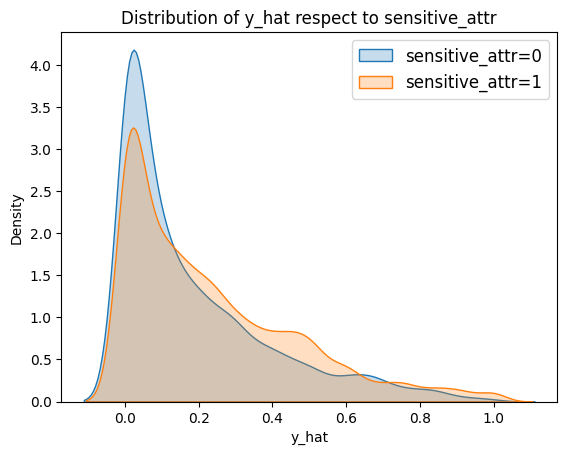

In [13]:
y_hat = train_metrics["train/y_hat"].reshape(-1)
sensitive_attr = train_metrics["train/sensitive"].reshape(-1)
import seaborn as sns
import matplotlib.pyplot as plt

# Separate y_hat based on sensitive_attr
y_hat_0 = y_hat[sensitive_attr == 0]
y_hat_1 = y_hat[sensitive_attr == 1]

# Create the distribution plots
sns.kdeplot(y_hat_0, label='sensitive_attr=0', shade=True)
sns.kdeplot(y_hat_1, label='sensitive_attr=1', shade=True)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Distribution of y_hat respect to sensitive_attr')
plt.xlabel('y_hat')
plt.ylabel('Density')

plt.show()